In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 34 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd
from pathlib import PurePath
import numpy as np
import data_construction as dc
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Preparation

In [142]:
# file
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(1)
df['SVENY10_60'] = df['SVENY10'].shift(60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()
df = df.iloc[:,:-2]

# test vs train
tscv = TimeSeriesSplit(n_splits=5, test_size=60)

# Taking on the results of yield into account
df_arima = df.iloc[:, [-1]]
df_arima_train = df_arima.iloc[df_arima.shape[0] - 500:-10, :]
df_arima_test = df_arima.iloc[-10:, :]

Performing Dicker Fuller test to identify stationarity of data

In [143]:
result = adfuller(df_arima_train['SVENY10'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -0.33528220527574704
p-value: 0.92035653981938


Dicker Fuller test on differenced data

In [144]:
# selecting d=1
result = adfuller(df_arima_train['SVENY10'].diff().dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -14.396370539851262
p-value: 8.653954186985521e-27


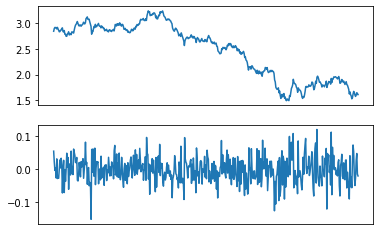

In [145]:
fig, axes = plt.subplots(2)
axes[0].plot(df_arima_train['SVENY10'].dropna())

axes[1].plot(df_arima_train['SVENY10'].diff().dropna())

axes[0].tick_params(axis='x', 
    which='both',      
    bottom=False,     
    top=False,
    labelbottom=False)

axes[1].tick_params(axis='x', 
    which='both',      
    bottom=False,     
    top=False,
    labelbottom=False)

plt.show()

The optimal level of difference is also the one with lower standard deviation

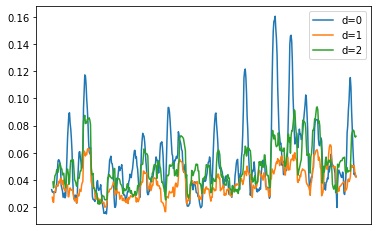

In [146]:
plt.plot(df_arima_train['SVENY10'].rolling(12).std())
plt.plot(df_arima_train['SVENY10'].diff(1).rolling(12).std())
plt.plot(df_arima_train['SVENY10'].diff(2).rolling(12).std())
plt.legend(['d=0', 'd=1', 'd=2'])
plt.tick_params(axis='x', 
    which='both',      
    bottom=False,     
    top=False,
    labelbottom=False)
plt.show()

Autocorrection graph to identify AR and MA terms

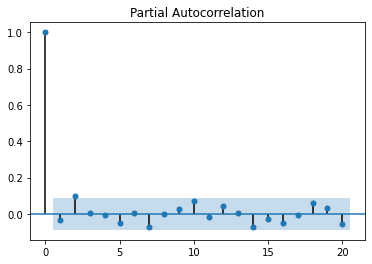

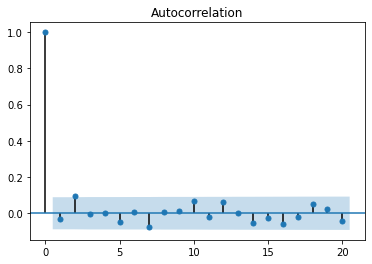

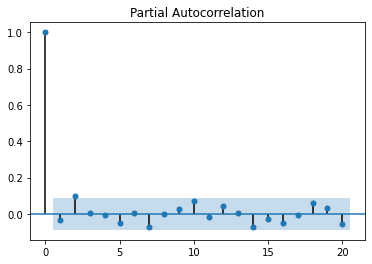

In [147]:
# p value = 1
plot_acf(df_arima_train['SVENY10'].diff().dropna(), lags=20)
plot_pacf(df_arima_train['SVENY10'].diff().dropna(), lags=20)

In [148]:
model = ARIMA(df_arima_train['SVENY10'], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.SVENY10   No. Observations:                  489
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 890.712
Method:                       css-mle   S.D. of innovations              0.039
Date:                Mon, 09 Aug 2021   AIC                          -1775.424
Time:                        10:36:59   BIC                          -1762.847
Sample:                             1   HQIC                         -1770.484
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0025      0.002     -1.469      0.142      -0.006       0.001
ar.L1.D.SVENY10    -0.0337      0.045     -0.745      0.457      -0.122       0.055
                                

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,0
count,489.000000
mean,0.000004
std,0.039187
min,-0.151280
25%,-0.024899
50%,-0.001063
75%,0.025122
max,0.120362


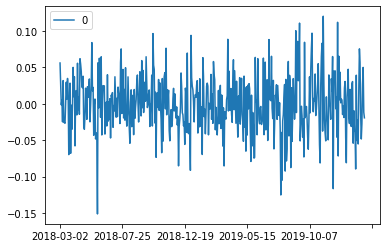

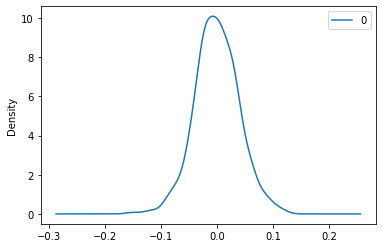

In [149]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
residuals.describe()

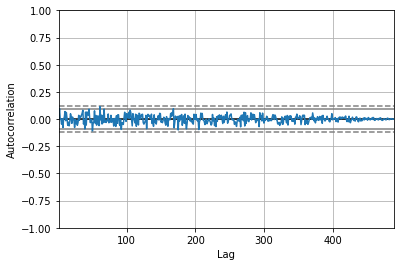

In [150]:
autocorrelation_plot(residuals)

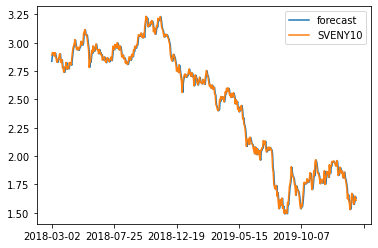

In [151]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [157]:
fc, se, conf = model_fit.forecast(10, alpha=0.05) 

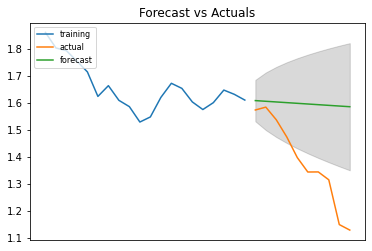

In [166]:
fc_series = pd.Series(fc, index=df_arima_test.index)
lower_series = pd.Series(conf[:, 0], index=df_arima_test.index)
upper_series = pd.Series(conf[:, 1], index=df_arima_test.index)

plt.figure()
plt.plot(df_arima_train.iloc[-20:,:], label='training')
plt.plot(df_arima_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.tick_params(axis='x', 
    which='both',      
    bottom=False,     
    top=False,
    labelbottom=False)
plt.show()
